## Markowitz MPT Mean Variance Optimization Model

Efficient Frontier Portfolio Model

This is a simple way to figure out how much money to put in each asset in a portfolio. It’s based on Modern Portfolio Theory (MPT), which tries to balance return and risk.

How it works:
- Each asset gets a **weight**, which means the % of your portfolio going into that asset.
- The portfolio return is just a **weighted average** of all expected returns.
- Risk is measured using **variance** 
- More importantly, we look at **covariance**, how assets move **together**.

Covariance matrix:
- Rows and columns represent each asset.
- Diagonal values = the variance of each asset.
- Off-diagonal = how much two assets move together.
- Covariance close to zero = unrelated. Negative = they move in opposite directions.

The goal:
- Find the **best mix of assets** (the weights) that gives us the **least risk** for a **target level of return**.
- This is a **constrained optimization problem**.

Constraints:
- Portfolio return = a target we set.
- All the weights must add up to 1 (investing 100% of your capital).

How we solve it:
- We use **Lagrange multipliers** to include the constraints in our optimization formula.
- Then we use **gradient descent** to iteratively adjust the weights and the lambda values.
- Gradient descent moves in the direction that reduces risk while still respecting the constraints.
- Since the function is **convex**, there’s only **one global minimum**, so we won’t get stuck.

Math (objective function with constraints folded in):

$$
\mathcal{L}(\mathbf{w}, \lambda_1, \lambda_2) = \mathbf{w}^T \Sigma \mathbf{w} 
- \lambda_1 (\mathbf{w}^T \mu - \mu_{\text{target}}) 
- \lambda_2 (\mathbf{1}^T \mathbf{w} - 1)
$$

- First part is the risk we want to minimize.
- Second part enforces the return we want.
- Third part enforces that weights add up to 1.

What we get at the end:
- A specific set of weights that give us the **minimum risk for a chosen return**.
- If we do this across many return levels, we trace out the **efficient frontier**.
- Each point on that frontier is a different **portfolio mix**, using the same assets.

This model assumes:
- Returns are normally distributed.
- Covariances stay constant.
- Risk = variance.
- Returns are "Expected Returns"

---

Fragilities (don’t treat this like gospel)

- **Variance is not real risk.** Howard Marks says:
  > “Risk means more things can happen than will happen.”
- Variance only tells you how much something wobbles. It says nothing about **loss**, **tail events**, or **liquidity**.
- Expected returns are fragile. A small change in inputs can flip your whole portfolio. But we’re not good at predicting returns anyway.
- In real life, correlations break. Assets that were “uncorrelated” start moving together in crises.
- Expected return is often derived from historical averages or short-term price trends — but these can be unstable and unreliable as true indicators of long-term return.
---

How to use this wisely

- Don’t treat this model as truth — it’s just a helpful tool.
- It’s a **starting point**, not an answer.
- Add stress testing, scenario analysis, and common sense.
- Look at max drawdown, not just variance.
- You can also explore **robust optimization**, **regime-based models**, or **Bayesian methods** that deal better with uncertainty.

In short:
- This is a clean and elegant model.
- But don’t be fooled by the math — always ask what it’s missing.


In [30]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# Ensure plots display nicely
plt.style.use('ggplot')

# Define your tickers
tickers = ['PLTR']  # You can change this list

In [29]:
# Download historical data from Yahoo Finance
prices = yf.download(tickers, start="2024-01-01", end="2025-01-01")['Adj Close']

# Drop rows with missing values (in case of holidays or IPO gaps)
prices.dropna(inplace=True)

# Show preview
print(prices.head())

Failed to get ticker 'PLTR' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PLTR']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Series([], Name: Adj Close, dtype: float64)


In [31]:
# Compute daily returns
returns_daily = prices.pct_change().dropna()

# Compute annualized expected returns and covariance matrix
mu = returns_daily.mean() * 252
cov = returns_daily.cov() * 252

# Preview results
print("\nExpected annual returns:")
print(mu.round(4))

print("\nAnnual covariance matrix:")
print(cov.round(4))

TypeError: Series.cov() missing 1 required positional argument: 'other'

In [10]:
# Convert to NumPy arrays
mu_vec = mu.values
cov_mat = cov.values
n_assets = len(tickers)

# Target return
target_return = 0.15

# Initialize weights randomly and normalize
weights = np.random.rand(n_assets)
weights /= weights.sum()

# Lagrange multipliers
lambda1 = 0.1  # for return constraint
lambda2 = 0.1  # for sum-to-1 constraint

# Hyperparameters
alpha = 0.01
n_iters = 2000

# History trackers
var_hist = []
weight_hist = []

In [11]:
for i in range(n_iters):
    # Compute gradients
    grad_w = 2 * cov_mat @ weights - lambda1 * mu_vec - lambda2 * np.ones(n_assets)
    grad_lambda1 = target_return - np.dot(mu_vec, weights)
    grad_lambda2 = 1 - np.sum(weights)

    # Update weights and lambdas
    weights -= alpha * grad_w
    lambda1 -= alpha * grad_lambda1
    lambda2 -= alpha * grad_lambda2

    # Project to feasible region (no shorts, normalize)
    weights = np.maximum(weights, 0)
    weights /= weights.sum()

    # Store history
    var = weights.T @ cov_mat @ weights
    var_hist.append(var)
    weight_hist.append(weights.copy())

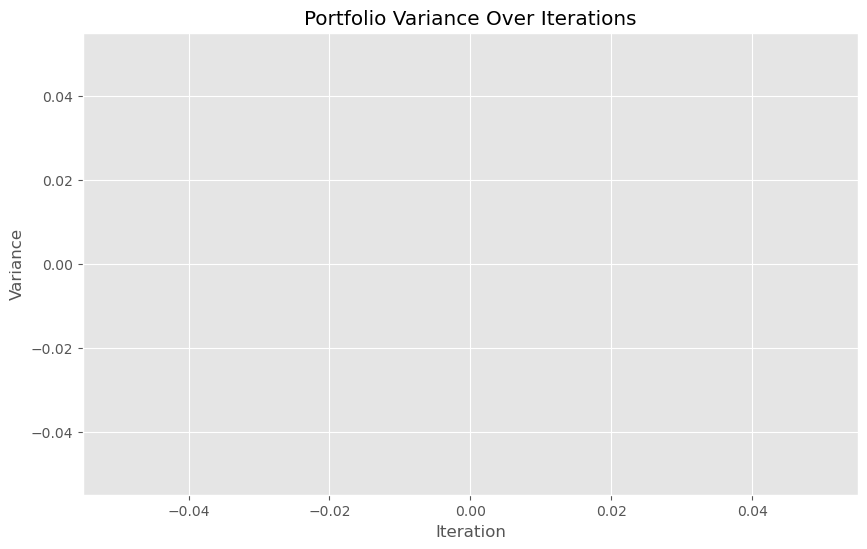

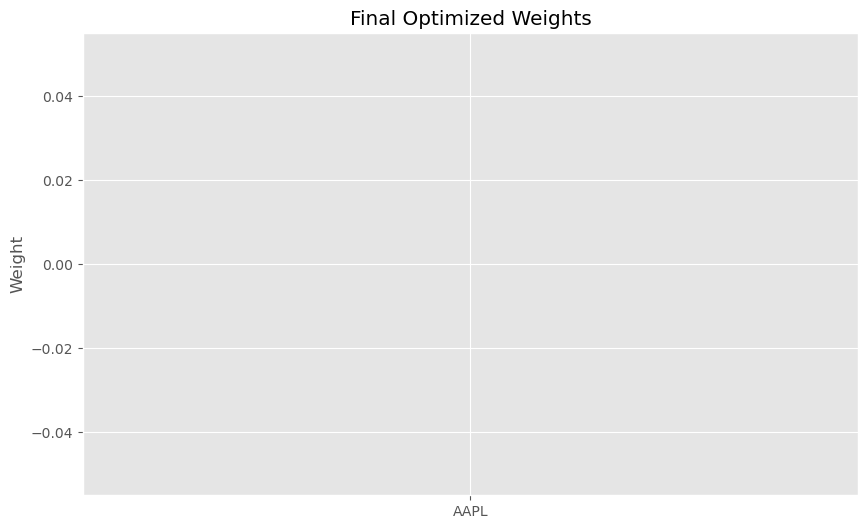

In [12]:
# Plot variance over iterations
plt.figure(figsize=(10, 6))
plt.plot(var_hist)
plt.title("Portfolio Variance Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Variance")
plt.show()

# Plot final weights
plt.figure(figsize=(10, 6))
plt.bar(tickers, weights)
plt.title("Final Optimized Weights")
plt.ylabel("Weight")
plt.show()

In [13]:
expected_return = np.dot(weights, mu_vec)
variance = weights.T @ cov_mat @ weights
volatility = np.sqrt(variance)

print("\n📊 Final Portfolio Stats")
print(f"Expected Return: {expected_return:.4f}")
print(f"Variance:        {variance:.4f}")
print(f"Volatility:      {volatility:.4f}")
print("\n📌 Final Weights:")
print(pd.Series(weights, index=tickers).round(4))


📊 Final Portfolio Stats
Expected Return: nan
Variance:        nan
Volatility:      nan

📌 Final Weights:
AAPL    NaN
MSFT    NaN
GOOGL   NaN
dtype: float64
